# Phase 3 Data Science Training Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exploratory Data Analysis

In [2]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
b1 = unpickle("cifar-10-batches-py\data_batch_1")
b2 = unpickle("cifar-10-batches-py\data_batch_2")
b3 = unpickle("cifar-10-batches-py\data_batch_3")
b4 = unpickle("cifar-10-batches-py\data_batch_4")
b5 = unpickle("cifar-10-batches-py\data_batch_5")
test = unpickle("cifar-10-batches-py//test_batch")

print(test.keys())
testData = test[b'data']
reshapedTest = testData.reshape(len(testData),3,32,32).transpose(0,2,3,1)
reshapedTest.shape



dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


(10000, 32, 32, 3)

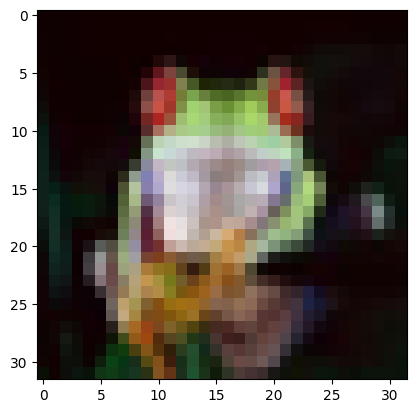

In [4]:
i = 102
plt.imshow(reshapedTest[i])

In [5]:
lableList = []
lableList += b1[b'labels']
lableList += b2[b'labels']
lableList += b3[b'labels']
lableList += b4[b'labels']
lableList += b5[b'labels']

dataList = np.concatenate((b1[b'data'],b2[b'data'],b3[b'data'],b4[b'data'],b5[b'data']),axis = 0)
dataList.shape

(50000, 3072)

In [6]:
dataList = dataList.reshape(len(dataList),3,32,32).transpose(0,2,3,1)
dataList.shape

(50000, 32, 32, 3)

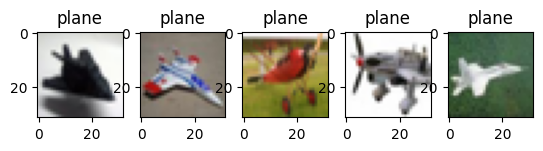

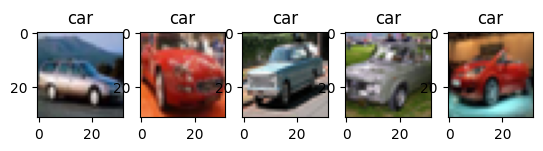

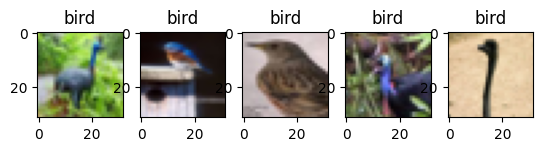

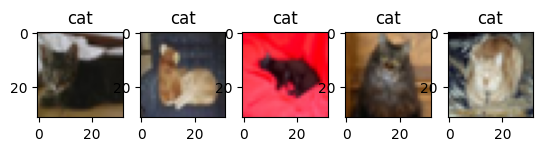

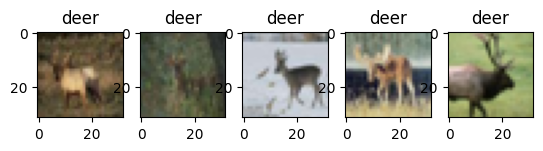

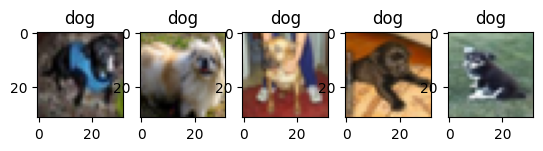

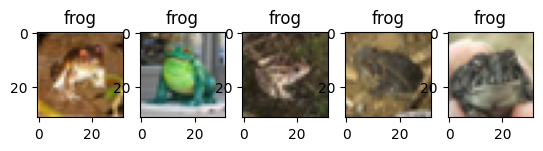

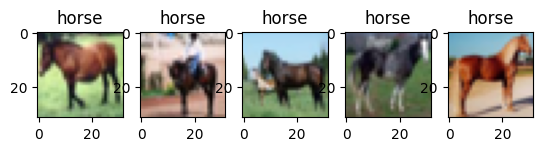

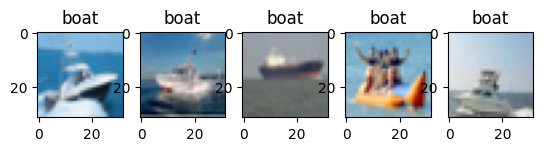

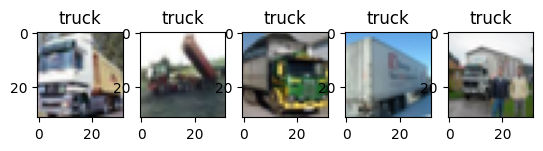

In [7]:
plane_list = []
car_list = []
bird_list = []
cat_list = []
deer_list = []
dog_list = []
frog_list = []
horse_list = []
ship_list = []
truck_list = []
list_of_lists = [plane_list,car_list,bird_list,cat_list,deer_list,dog_list,frog_list,horse_list,ship_list,truck_list]
names =  ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "boat", "truck"]

for list in range(len(list_of_lists)):
    for i in range(len(lableList)):
        if lableList[i] == list:
            list_of_lists[list].append(i)

j = 0
for list in list_of_lists:
    for i in range(5):
        img = dataList[list[i]]
        plt.subplot(1,5,i+1)
        plt.title(names[j])
        plt.imshow(img)
    j += 1    
    plt.show()



I will pick frogs for this model.

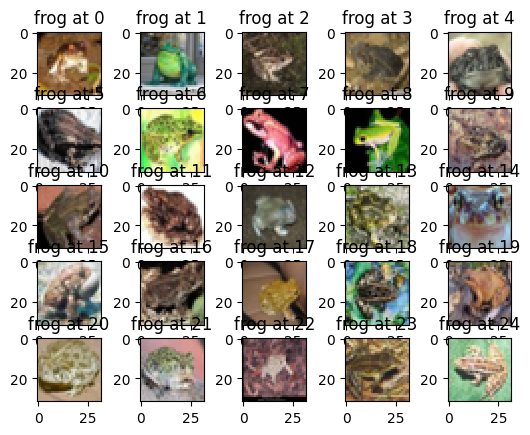

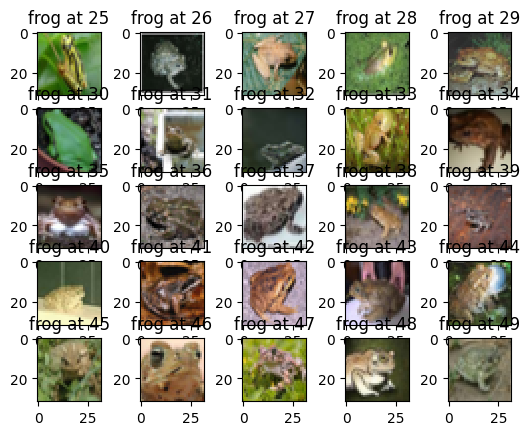

In [8]:
boat_index = list_of_lists[6]
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.title(f"frog at {i}")

    plt.imshow(dataList[boat_index[i]])

plt.show()

for j in range(25):
    plt.subplot(5,5,j+1)    # the number of images in the grid is 5*5 (25)
    i+=1
    plt.title(f"frog at {i}")

    plt.imshow(dataList[boat_index[i]])

plt.show()



# Data Processing

In [9]:
train_x = dataList
train_y = np.array(lableList)

test_x = reshapedTest
test_y = np.array(test[b'labels'])

train_x, test_x = train_x / 255.0, test_x / 255.0

# Data Modelling

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks,datasets, models
from datetime import datetime
import kerastuner as kt

C:\Users\jamie\AppData\Local\Temp\ipykernel_5116\3082692706.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [11]:
# def generateModel():
#     """
#     Make a Keras Sequential Model.
#     Feel free to change the layout of the layers.

#     Read more about keras here: https://keras.io/api/
#     Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
#     """
#     model = Sequential(name="Image_Recognition_Model")
#     model.add(Input(shape=(32,32,3))) # Input layer.

#     model.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.

#     model.add(layers.Dense(3000, activation="relu")) # Example Hidden Layer 1. Has 40 Nodes.
#     model.add(layers.Dense(1000, activation="sigmoid")) # Example Hidden Layer 2. Has 25 Nodes.
#     model.add(layers.Dense(200, activation="tanh")) # Example Hidden Layer 3. Has 15 Nodes.

#     model.add(layers.Dense(1, activation="sigmoid", name="Output_Probability")) # Output layer.

#     model.compile(
#         optimizer=optimizers.SGD(learning_rate=0.01),
#         loss=losses.MeanAbsoluteError(),
#         metrics=['accuracy']
#     )

#     return model

In [18]:
import os


def model_builder(hp):
    mod = keras.Sequential()

    mod.add(keras.layers.Flatten(input_shape=(32,32,3)))
    hp_units = hp.Int('units', min_value = 32, max_value=512, step=32)
    mod.add(keras.layers.Dense(units=hp_units, activation='relu'))
    mod.add(keras.layers.Dropout(0.2))
    mod.add(keras.layers.Dense(10, activation='softmax'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    log_dir = os.path.join(r'output\logs' , datetime.now().strftime("%Y-%m-%d-%H%M%S"))

    # Callbacks for QoL.
    tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    mod.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

    return mod

In [19]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', max_epochs=10, factor=3, directory='dir', project_name='khyperband')
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project dir\khyperband\oracle.json
INFO:tensorflow:Reloading Tuner from dir\khyperband\tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [20]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_x, train_y, epochs=10, validation_split=0.2, callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [21]:
hyperPram = tuner.get_best_hyperparameters()[0]

In [22]:
mod = tuner.hypermodel.build(hyperPram)
mod.summary()
mod.fit(train_x,train_y,epochs = 5,validation_split = 0.2)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 384)               1180032   
                                                                 
 dropout_3 (Dropout)         (None, 384)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                3850      
                                                                 
Total params: 1,183,882
Trainable params: 1,183,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1250/1250 [==============================] - 12s 9ms/step - loss: 1.9179 - accuracy: 0.3136 - val_loss: 1.7831 - val_accuracy: 0.3718
Epoch 2/5
1250/1250 [===========

In [23]:
prediction = mod.predict(test_x)

313/313 [==============================] - 1s 3ms/step


In [ ]:
model.save('output/my_model')